In [1]:
import numpy as np
import sys
import time
import h5py as h5
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from scipy.ndimage import gaussian_filter as sngaussian_filter

sys.path.append(r"C:\Users\hyli\Documents\GitHub\CrystalDiff")
display(HTML("<style>.container { width:90% !important; }</style>"))

from numba import cuda
from pyculib import fft as cufft
from CrystalDiff import util, pulse, lclsutil, groutine

In [23]:
############################################################################################################
# ----------------------------------------------------------------------------------------------------------
#
#                       Step 1: Prepare the devices and pulses
#
# ----------------------------------------------------------------------------------------------------------
############################################################################################################
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                               Crystal
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Reflection numbers
reflect_num = 32

# Set up bragg angle
h_length = 2. * np.pi / (1.9201 * 1e-4)
hlen_vals = np.array([h_length, ] * reflect_num)
 
bragg_angle = np.radians(18.836)
# Set up the angles
d_angle_1 = 10e-6

theta = np.pi / 2. + bragg_angle + d_angle_1
theta_vals = np.mod(np.arange(reflect_num, dtype=np.float64), 2.) * np.pi + theta

rho = bragg_angle - np.pi / 2. + d_angle_1
rho_vals = np.mod(np.arange(reflect_num, dtype=np.float64), 2.) * np.pi + rho

tau_vals = [0.,] * reflect_num

# Set up the surface position
surface_points = np.zeros((reflect_num, 3), dtype=np.float64)
surface_points[:, 2] = np.mod(np.arange(reflect_num, dtype=np.float64), 2.) * 1e4

# Initialize the crystals
crystal_list = lclsutil.get_crystal_list(num=reflect_num,
                                         hlen_vals=hlen_vals,
                                         rho_vals=rho_vals,
                                         theta_vals=theta_vals,
                                         tau_vals=tau_vals,
                                         surface_points=surface_points,
                                         chi0=complex(-0.97631E-05, 0.14871E-06),
                                         chih_sigma=complex(0.59310E-05, -0.14320E-06),
                                         chihbar_sigma=complex(0.59310E-05, -0.14320E-06),
                                         chih_pi=complex(0.46945E-05, -0.11201E-06),
                                         chihbar_pi=complex(0.46945E-05, -0.11201E-06)
                                         )

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                               Pulse
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Set up the pulse
my_pulse = pulse.GaussianPulse3D()

energy_center = 10.
k_len = util.kev_to_wave_number(energy=energy_center)

my_pulse.polar = np.array([0., 1., 0.], dtype=np.complex128)

my_pulse.k0 = np.array([0., 0., k_len])
my_pulse.n = my_pulse.k0 / util.l2_norm(my_pulse.k0)
my_pulse.omega0 = k_len * util.c

my_pulse.sigma_x = 100.  # sigma_t
my_pulse.sigma_y = 100.  # sigma_t  # fs
my_pulse.sigma_z = 1.  # fs
my_pulse.sigma_mat = np.diag(np.array([my_pulse.sigma_x ** 2,
                                       my_pulse.sigma_y ** 2,
                                       my_pulse.sigma_z ** 2], dtype=np.float64))
my_pulse.sigma_mat *= util.c ** 2

magnitude_peak = 1.
my_pulse.scaling = complex(my_pulse.sigma_x * my_pulse.sigma_y *
                           my_pulse.sigma_z * (util.c ** 3), 0.) * magnitude_peak

pre_length = 3e4
my_pulse.x0 = np.array([0., 0., -pre_length])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Arrange the crystal separation
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
path_sections = [0.,] + [2e4,] * (reflect_num - 1)

intersection_points, kout_vec_list = lclsutil.get_point_with_definite_path(kin_vec=my_pulse.k0,
                                                                           path_sections=path_sections,
                                                                           crystal_list=crystal_list)

crystal_list = lclsutil.get_crystal_list(num=reflect_num,
                                         hlen_vals=hlen_vals,
                                         rho_vals=rho_vals,
                                         theta_vals=theta_vals,
                                         tau_vals=tau_vals,
                                         surface_points=np.copy(intersection_points),
                                         chi0=complex(-0.97631E-05, 0.14871E-06),
                                         chih_sigma=complex(0.59310E-05, -0.14320E-06),
                                         chihbar_sigma=complex(0.59310E-05, -0.14320E-06),
                                         chih_pi=complex(0.46945E-05, -0.11201E-06),
                                         chihbar_pi=complex(0.46945E-05, -0.11201E-06)
                                         )

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Get the observation point
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
post_length = 6e4
observation = (intersection_points[-1] +
               post_length * kout_vec_list[-1] / util.l2_norm(kout_vec_list[-1]))

total_path = (pre_length + post_length +
              util.get_total_path_length(intersection_point_list=intersection_points))
print("The total propagation length is {:.2f}um.".format(total_path))
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Change frame
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#"""
(my_pulse,
 crystal_list,
 observation,
 rot_mat_dict) = lclsutil.get_to_kout_frame(kin=my_pulse.k0,
                                            kout=kout_vec_list[-1],
                                            displacement=-intersection_points[-1],
                                            obvservation=observation,
                                            pulse=my_pulse,
                                            crystal_list=crystal_list,
                                            aux = np.array([1., 0., 0.], dtype=np.float64)
                                           )
#"""
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Get the momentum mesh
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
number_x = 2
number_y = 500
number_z = 10 ** 5
kx_grid, ky_grid, kz_grid, axis_info = lclsutil.get_k_mesh_3d(number_x=number_x,
                                                              number_y=number_y,
                                                              number_z=number_z,
                                                              delta_e_x=1e-50,
                                                              delta_e_y=5e-4,
                                                              delta_e_z=1e-3 / util.c)
kz_grid += k_len

# Apply fft shift
kx_grid = np.ascontiguousarray(np.fft.fftshift(kx_grid))
ky_grid = np.ascontiguousarray(np.fft.fftshift(ky_grid))
kz_grid = np.ascontiguousarray(np.fft.fftshift(kz_grid))

The total propagation length is 710000.00um.


In [24]:
# Set the range of the index to save
z_idx_range = 500
num1 = 450
num2 = 50
d_num = 512

# Do the calculation
tic = time.time()

(result_3d_dict,
 result_2d_dict,
 check_dict) = groutine.get_bragg_reflected_field(crystal_list=crystal_list,
                                                  total_path=total_path, 
                                                  observation=observation, 
                                                  my_pulse=my_pulse,
                                                  kx_grid=kx_grid,
                                                  ky_grid=ky_grid,
                                                  kz_grid=kz_grid, 
                                                  number_x=number_x,
                                                  number_y=number_y, 
                                                  number_z=number_z,
                                                  z_idx_range=z_idx_range, 
                                                  num1=num1, 
                                                  num2=num2,
                                                  d_num=512)

toc = time.time()
print("It takes {:.2f} seconds to finish the calculation".format(toc - tic))

It takes 0.97 seconds to prepare the variables.
It takes 195.41 seconds to finish the calculation


In [25]:
field = np.fft.ifftshift(np.fft.ifft(result_2d_dict['y_field_2d'], axis=0), axes=0)

np.save("C:/Users/hyli/Desktop/multiple_reflections_{}_.npy".format(reflect_num), field) 

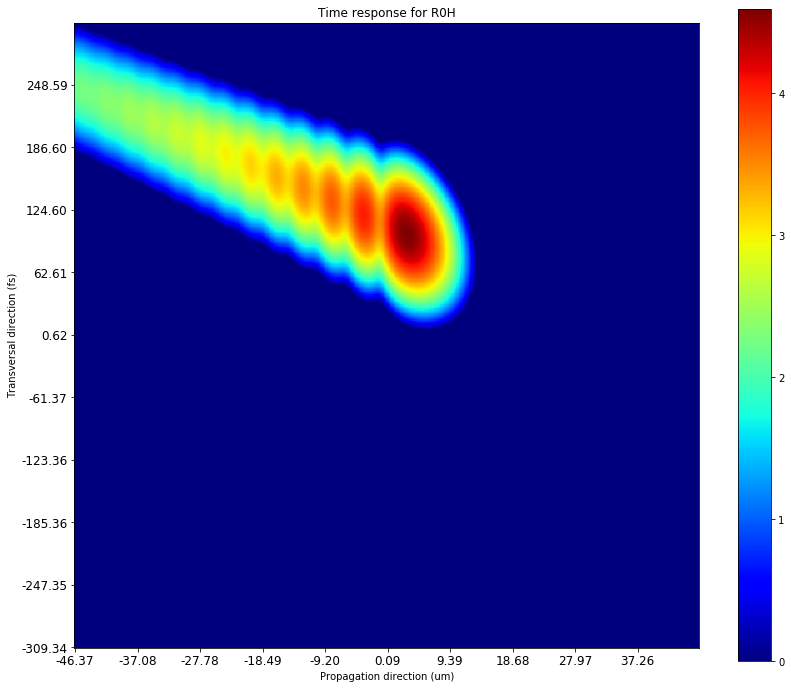

In [26]:
# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(12)
fig.set_figwidth(14)

ratio = (((axis_info['z_idx'][z_idx_range - 1] - axis_info['z_idx'][0]) /z_idx_range) /
         ((axis_info['y_idx'][-1] - axis_info['y_idx'][0]) / number_y))

field = np.fft.ifftshift(np.fft.ifft(result_2d_dict['y_field_2d'], axis=0), axes=0)

im = axes.imshow(np.log(np.abs( field )),
                 vmin= 0.,
                 #vmax = 12.,
                 cmap='jet', 
                 origin='lower',
                 #aspect = 1/util.c,
                 )

axes.set_title("Time response for R0H")
axes.set_yticks(np.arange(0, number_y, step=50))
axes.set_yticklabels(axis_info["y_idx_tick"][::50], fontsize=12)
axes.set_xticks(np.arange(0, z_idx_range, step=50))
axes.set_xticklabels(axis_info["z_idx_tick"][number_z//2 - z_idx_range//2:
                                              number_z//2 + z_idx_range//2:50], fontsize=12)

axes.set_xlabel("Propagation direction (um)")
axes.set_ylabel("Transversal direction (fs)")
fig.colorbar(im, ax=axes)
# Show the canvas

plt.show()